## European Options

As mentioned in the supporting research paper, this project aims to price vanilla options under geometric Brownian motion (GBM) in a risk-netural framework $\mathbb{Q}$. This document kickstarts the implementation of the ideas discussed in the paper, starting with pricing European vanilla options. We start by pricing said claims via the Black-76 model, which uses the no-arbitrage forward price $F_t^{(T)}$ in the Black-Scholes formula, as opposed to the spot price $S_t$. We assert checks on put-call parity, no-arbitrage bounds and monotonicity and convexity and build plots to understand how the price of the given contingent claim changes with respect to changes in strike price $K$ and underlying asset price $S_t$.

We then move on and look to build a pricing engine for the same European vanilla claims via Monte Carlo simulation with antithetic variates for variance reduction. The main purpose of this is to have a validation tool for the Black-76 model, particularly for options that have extreme parameter values or are deeply in-the-money or out-the-money. We build a two-tailed, $95\%$ confidence interval and ensure our Black-76 price lies within this interval. Plots for convergence of the Monte Carlo price to the Black-Scholes price are given, which enforce our reliance on the strong law of large numbers. We compute the Greeks using finite difference methods, which can handle extreme parameter values better than the analytic formulae from the Black-76 model. 

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Allow plots to be exported
from pathlib import Path

print("Working directory:", Path.cwd())

FIG_DIR = Path("project/figures/appendixC")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name, fmt="pdf"):
    path = FIG_DIR / f"{name}.{fmt}"
    fig.savefig(path, bbox_inches="tight")
    print("Saved:", path)

Working directory: /Users/milanleal/Documents/Vanilla_Pricing


In [3]:
# Set parameter values
St = 100.0
tau = 1.0
K = 100.0
r = 0.05
q = 0.02
sigma = 0.20
M = int(1e6)

### The Black-76 model

Inside the filtered probability space $(\Omega, \mathcal{F}, \{\mathcal{F}_t\}_{t\ge 0}, \mathbb{Q}^T)$ with the $T$-forward measure, we define our GBM to be 
$$dS_t = (r-q)S_tdt + \sigma S_tdW_t^{\mathbb{Q}^T}$$

Let $\tau := T - t$ be the time until maturity. Then the no-arbitrage forward price is $F_t^{(T)} := S_te^{(r-q)\tau}$ so that the Black-Scholes formula can be expressed as
$$C_t = e^{-r\tau}(F_t^{(T)} \Phi(\delta_1) - K \Phi(\delta_2)), \quad P_t = e^{-r\tau}(K\Phi(-\delta_2) - F_t^{(T)}\Phi(-\delta_1))$$

where $\Phi: \mathbb{R} \to [0,1]$ is the distribution function of a standard Gaussian random variable $Z\sim\mathcal{N}(0,1)$, and
$$ \delta_1 = \frac{\log(F_t^{(T)}/K) + \frac{1}{2}\sigma^2 \tau}{\sigma \sqrt{\tau}}, \quad \delta_2 = \delta_1 - \sigma \sqrt{\tau} $$

If $S_t = 0$, we set $C(t,S_t) = 0$ and $P(t,S_t) = Ke^{-r\tau}$. If $\tau = 0$, we are at maturity and set $C(T,S_T) = (S_T - K)^+$ and $P(T,S_T) = (K - S_T)^+$. If $\sigma = 0$, the price is deterministic so we set $C(t,S_t) = e^{-r\tau}(F_t^{(T)} - K)^+$ and $P(t,S_t) = e^{-r\tau}(K - F_t^{(T)})^+$.

In [4]:
# Price European put and call options with the forward form Black-Scholes formula
def european_bs_price(St, tau, K, r, q, sigma, option_type):

    """
    Computes the price of a European call or put option using the Black-Scholes formula

    Parameters:
    St: Underlying asset price at time t
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Dividend yield
    sigma: Annualised volatility
    option_type: Option type

    Returns:
    price: European call or put option price
    """

    epsilon = 1e-12

    if option_type not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'.")

    if K <= 0.0:
        raise ValueError("K must be strictly positive")
        
    if St < 0.0 or tau < 0.0 or sigma < 0.0:
        raise ValueError("St, tau, sigma must be non-negative.")

    Ft = St * np.exp((r - q) * tau)
    discount = np.exp(-r * tau)
    
    if St <= epsilon:
        if option_type == "call":
            price = 0.0
        else:
            price = K * discount

    elif tau <= epsilon:
        if option_type == "call":
            price = np.maximum(St - K, 0.0) 
        else:
            price = np.maximum(K - St, 0.0)

    elif sigma <= epsilon:
        if option_type == "call":
            price = discount * np.maximum(Ft - K, 0.0)
        else:
            price = discount * np.maximum(K - Ft, 0.0)

    else:
        d1 = (np.log(Ft / K) + 0.5 * sigma**2 * tau) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)
        if option_type == "call":
            price = discount * (Ft * norm.cdf(d1) - K * norm.cdf(d2))
        else:
            price = discount * (K * norm.cdf(-d2) - Ft * norm.cdf(-d1))

    return price

# Print Black-Scholes European call and put option prices
print(f"Black-Scholes European call price: {european_bs_price(St, tau, K, r, q, sigma, option_type = 'call'):.6f}")
print(f"Black-Scholes European put price: {european_bs_price(St, tau, K, r, q, sigma, option_type = 'put'):.6f}")

Black-Scholes European call price: 9.227006
Black-Scholes European put price: 6.330081


### Put-call parity

Put-call parity can be derived from considering a portfolio $\Pi_t$ at time $t$ consisting of a long call option $C_t$ and a short put option $P_t$. Then $\Pi_t := C_t - P_t$ with payoff $\Psi(S_T) = (S_T - K)^+ - (K - S_T)^+$. Thus, put-call parity enforces the following equality

$$C_t - P_t = e^{-r\tau}(F_t^{(T)} - K)$$

In [5]:
# Test put-call parity with relative tolerance 1e-8 and absolute tolerance 1e-10
def test_put_call_parity(St, tau, K, r, q, sigma):

    Ft = St * np.exp((r - q) * tau)
    Ct = european_bs_price(St, tau, K, r, q, sigma, option_type = "call")
    Pt = european_bs_price(St, tau, K, r, q, sigma, option_type = "put")

    discount = np.exp(-r * tau)
    lhs = Ct - Pt; rhs = discount * (Ft - K)
    
    assert np.isclose(lhs, rhs, rtol = 1e-8, atol = 1e-10), f"Put-call parity failed. Error: {abs(lhs - rhs)}"

### Lower and upper bounds

By put-call parity and monotonicity of the contingent claim's price $V(t,S_t)$ in $\sigma$, we find the upper and lower bounds for the European call and put options are, respectively
$$0 \le C(t,S_t) \le S_te^{-q\tau}, \quad 0 \le P(t,S_t) \le Ke^{-r\tau}$$

In [6]:
# Test lower and upper bounds
def test_lb_ub(St, tau, K, r, q, sigma, tol):

    Ct = european_bs_price(St, tau, K, r, q, sigma, option_type = "call")
    Pt = european_bs_price(St, tau, K, r, q, sigma, option_type = "put")

    div_discount = np.exp(-q * tau)
    discount = np.exp(-r * tau)

    call_lb = np.maximum(St * div_discount - K * discount, 0.0)
    put_lb = np.maximum(K * discount - St * div_discount, 0.0)
    
    call_ub = St * div_discount
    put_ub = K * discount

    assert (call_lb - tol <= Ct <= call_ub + tol), f"European Black-Scholes call out of bounds: C = {Ct:.6f}, No-arb interval = [{call_lb:.6f}, {call_ub:.6f}]"
    assert (put_lb - tol <= Ct <= put_ub + told), f"European Black-Scholes put out of bounds: P = {Pt:.6f}, No-arb interval = [{put_lb: .6f},  {put_ub:.6f}]"

### Monotonicity and convexity

The payoff functions of a European call and European put option are piecewise linear and convex in strike price. Hence, we can form the following relations and validate through plots visually
$$\partial_KC(t,S_t) \le 0, \quad \partial_{KK}C(t,S_t) \ge 0$$
$$\partial_KP(t,S_t) \ge 0, \quad \partial_{KK}P(t, S_t) \ge 0$$

Saved: project/figures/appendixC/C1_monotonicity_convexity.pdf


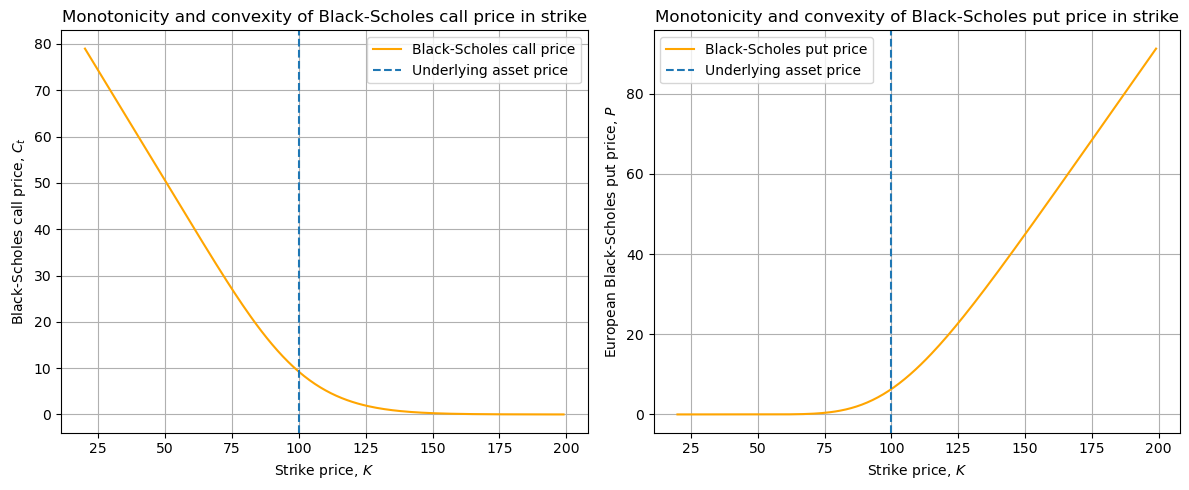

In [7]:
# Set up linear x-axis and compute European Black-Scholes call and put prices as NumPy arrays for various strikes
Ks = np.arange(20, 200, 1)
bs_calls = np.array([european_bs_price(St, tau, K, r, q, sigma, option_type = "call") for K in Ks])
bs_puts = np.array([european_bs_price(St, tau, K, r, q, sigma, option_type = "put") for K in Ks])

#Plot monotonicity and convexity of European Black-Scholes call and put prices in strike
fig, (ax_calls, ax_puts) = plt.subplots(1, 2, figsize = (12, 5))

ax_calls.plot(Ks, bs_calls, linestyle = "-", color = "orange", label = "Black-Scholes call price")
ax_calls.axvline(St, linestyle = "--", label = "Underlying asset price")
ax_calls.set_xlabel("Strike price, $K$")
ax_calls.set_ylabel("Black-Scholes call price, $C_t$")
ax_calls.set_title("Monotonicity and convexity of Black-Scholes call price in strike")
ax_calls.legend()
ax_calls.grid()

ax_puts.plot(Ks, bs_puts, linestyle = "-", color = "orange", label = "Black-Scholes put price")
ax_puts.axvline(St, linestyle = "--", label = "Underlying asset price")
ax_puts.set_xlabel("Strike price, $K$")
ax_puts.set_ylabel("European Black-Scholes put price, $P$")
ax_puts.set_title("Monotonicity and convexity of Black-Scholes put price in strike")
ax_puts.legend()
ax_puts.grid()

fig.tight_layout()
save_fig(fig, "C1_monotonicity_convexity", fmt="pdf")
plt.show()

### Asymptotic behaviour of $S_t$

We saw above that $C(t,S_t) \to 0$ and $P(t,S_t) \to Ke^{-r\tau}$ as $S_t\to0$. Below is a visual representation of these limits. Since Delta is, by definition, the rate of change of the option price $V(t,S_t)$ with respect to the underlying asset $S_t$, this also is a good visualisation for how Delta at time $t$ changes over various underlying asset price changes.

Saved: project/figures/appendixC/C2_asymptotics_S_limits.pdf


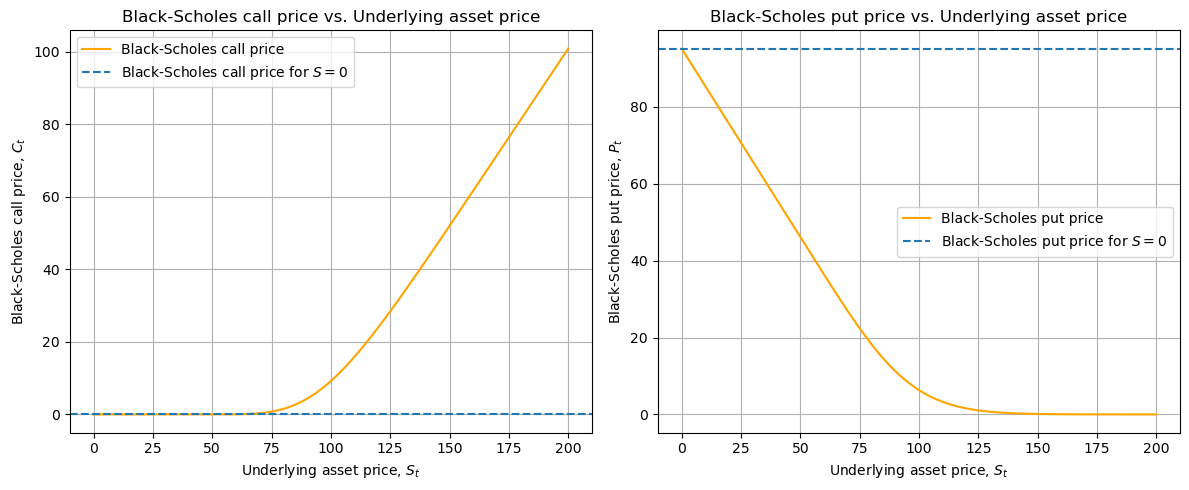

In [8]:
# Set up linear x-axis and compute European Black-Scholes call and put prices as NumPy arrays for various underlying asset prices
Sts = np.arange(0.01, 200, 0.01)
bs_calls = np.array([european_bs_price(St, tau, K, r, q, sigma, option_type = "call") for St in Sts])
bs_puts = np.array([european_bs_price(St, tau, K, r, q, sigma, option_type = "put") for St in Sts])

# Plot asymptotic behaviour of European Black-Scholes call and put prices as S --> 0
fig, (ax_calls, ax_puts) = plt.subplots(1, 2, figsize = (12, 5))

ax_calls.plot(Sts, bs_calls, linestyle = "-", color = "orange", label = "Black-Scholes call price")
ax_calls.axhline(0.0, linestyle = "--", label = "Black-Scholes call price for $S=0$")
ax_calls.set_xlabel("Underlying asset price, $S_t$")
ax_calls.set_ylabel("Black-Scholes call price, $C_t$")
ax_calls.set_title("Black-Scholes call price vs. Underlying asset price")
ax_calls.grid()
ax_calls.legend()

ax_puts.plot(Sts, bs_puts, linestyle = "-", color = "orange", label = "Black-Scholes put price")
ax_puts.axhline(K * np.exp(-r * tau), linestyle = "--", label = "Black-Scholes put price for $S=0$")
ax_puts.set_xlabel("Underlying asset price, $S_t$")
ax_puts.set_ylabel("Black-Scholes put price, $P_t$")
ax_puts.set_title("Black-Scholes put price vs. Underlying asset price")
ax_puts.grid()
ax_puts.legend()

fig.tight_layout()
save_fig(fig, "C2_asymptotics_S_limits", fmt="pdf")
plt.show()

### Analytic Greeks

For any parameter $\theta$ of our model, its Greek measures the sensitivity of the contingent claim $V(\theta)$ to changes in $\theta$. The Greeks we will compute are as follows
$$\Delta(t) = \partial_SV(t, S_t), \quad \Gamma(t) = \partial_{SS}V(t, S_t), \quad \mathcal{V}(t) = \partial_\sigma V(t, S_t), \quad \rho(t) = \partial_rV(t, S_t), \quad \Theta(t) = \partial_tV(t,S_t) $$

Since we have an analytic solution for the European option price in forward form, we can easily compute the partial derivatives with respect to the chosen parameter to also yield analytic solutions for the Greeks.

In [9]:
# Compute the analytic Greeks for European call and put options
def european_greek_analytic(St, tau, K, r, q, sigma, option_type, greek_type):
    
    """
    Computes the Greeks (delta, gamma, vega, rho, theta) analytically for European Black-Scholes call and put options

    Parameters:
    St: Underlying asset price at time t
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Dividend yield
    sigma: Annualised volatility
    option_type: Option type
    greek_type: Greek

    Returns:
    greek: Given Greek for the chosen European option type
    """

    epsilon = 1e-12
    
    if option_type not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'.")

    if greek_type not in ("delta", "gamma", "vega", "rho", "theta"):
        raise ValueError("greek_type must be one of 'delta', 'gamma', 'vega', 'rho', 'theta'.")

    if St <= epsilon or tau <= epsilon or K <= epsilon or sigma <= epsilon:
        raise ValueError("Anayltic Greeks are only defined for strictly positive St, tau, K, sigma.")

    Ft = St * np.exp((r - q) * tau)
    d1 = (np.log(Ft / K) + 0.5 * sigma**2 * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    cd1 = norm.cdf(d1)
    pd1 = norm.pdf(d1)
    cd2 = norm.cdf(d2)

    discount = np.exp(-r * tau)
    div_discount = np.exp(-q * tau)

    if greek_type == "delta":
        if option_type == "call":
            greek = div_discount * cd1
        else:
            greek = div_discount * (cd1 - 1)

    elif greek_type == "gamma":
        greek = (div_discount * pd1) / (St * sigma * np.sqrt(tau))

    elif greek_type == "vega":
        greek = St * div_discount * pd1 * np.sqrt(tau)

    elif greek_type == "rho":
        if option_type == "call":
            greek = K * tau * discount * cd2
        else:
            greek = -K * tau * discount * (1 - cd2)

    else:
        if option_type == "call":
            greek = (- (St * div_discount * pd1 * sigma) / (2 * np.sqrt(tau)) 
                     - r * K * discount * cd2 
                     + q * St * div_discount * cd1)
        else:
            greek = (- (St * div_discount * pd1 * sigma) / (2 * np.sqrt(tau)) 
                     + r * K * discount * (1 - cd2) 
                     - q * St * div_discount * (1 - cd1))
    
    return greek 

# Print analytic delta for European call and put options
print(f"European Black-scholes call analytic delta: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'call', greek_type = 'delta'):.6f}")
print(f"European Black-scholes put analytic delta: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'put', greek_type = 'delta'):.6f}")

# Print analytic gamma for European call and put options
print(f"European Black-scholes call analytic gamma: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'call', greek_type = 'gamma'):.6f}")
print(f"European Black-scholes put analytic gamma: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'put', greek_type = 'gamma'):.6f}")

# Print analytic vega for European call and put options
print(f"European Black-scholes call analytic vega: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'call', greek_type = 'vega'):.6f}")
print(f"European Black-scholes put analytic vega: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'put', greek_type = 'vega'):.6f}")

# Print analytic rho for European call and put options
print(f"European Black-scholes call analytic rho: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'call', greek_type = 'rho'):.6f}")
print(f"European Black-scholes put analytic rho: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'put', greek_type = 'rho'):.6f}")

# Print analytic theta for European call and put optionsor Black-Scholes:
print(f"European Black-scholes call analytic theta: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'call', greek_type = 'theta'):.6f}")
print(f"European Black-scholes put analytic theta: {european_greek_analytic(St, tau, K, r, q, sigma, option_type = 'put', greek_type = 'theta'):.6f}")

European Black-scholes call analytic delta: 0.586851
European Black-scholes put analytic delta: -0.393348
European Black-scholes call analytic gamma: 0.018951
European Black-scholes put analytic gamma: 0.018951
European Black-scholes call analytic vega: 37.901158
European Black-scholes put analytic vega: 37.901158
European Black-scholes call analytic rho: 49.458109
European Black-scholes put analytic rho: -45.664833
European Black-scholes call analytic theta: -5.089319
European Black-scholes put analytic theta: -2.293569


### Implied Volatility

Implied Volatility, $\sigma_{\text{imp}}$, is the value for the volatility parameter which, when plugged in to the Black-Scholes formula, matches the price of the option in the market. That is,
$$V^{\text{BS}}(S_t, \tau, K, r, q, \sigma_{imp}) = V^{\text{mkt}}$$
Since $\partial_\sigma V(t,S_t)$ exists and is strictly positive for all $\tau > 0$, and the price $V^{\text{BS}}$ is a continuous function in $\sigma$, the value $\sigma_{\text{imp}} > 0$ always exists and is unique.

There is no analytic formula to solve for implied volatility, hence we will use a combination of two methods. We start, for reasonable $\sigma$, using Newton's method. Let $f(\sigma) = V^{\text{BS}}(S_t, \tau, K, r, q, \sigma) - V^{\text{mkt}}$. Then, we wish to find the unique root of $f$. From a simple Taylor expansion of $f$ around an initial volatility estimate $\sigma_0 > 0$, the $n^{th}$ iteration is
$$\sigma_n = \sigma_{n-1} - \frac{f(\sigma_{n-1})}{f'(\sigma_{n-1})}$$
This iteration continues until the price discrepancy between the Black-Scholes price and the market price is less than a predefined tolerance, $\varepsilon_V$. For small Vega, Newton's method is unstable and so we convert to the bisection method, which solves the problem with a linear convergence rate instead of quadratic, but is stable unconditionally. We start by creating a volatility bracket $[\sigma_\ell, \sigma_u]$ and compute the midpoint $\sigma_{\text{mid}}$. Then, we follow the algorithm:

\begin{aligned}
        & \mathbf{1.} \quad \text{If } f(\sigma_{\text{mid}}) = 0 \text{, root found. Terminate iteration} \\[2pt]
        & \mathbf{2.} \quad \text{If } f(\sigma_{\text{mid}}) > 0 \text{, set } \sigma_{\text{mid}} \to \sigma_u \\[2pt]
        & \mathbf{3.} \quad \text{If } f(\sigma_{\text{mid}}) < 0 \text{, set } \sigma_{\text{mid}} \to \sigma_\ell \\ 
\end{aligned}
Similar to Newton's method, we stop the iteration when either we find the exact root $f(\sigma_{\text{mid}}) = 0$, or length of the interval $[\sigma_\ell, \sigma_u]$ is reduced below a predefined threshold, $\varepsilon_\sigma$.

In [10]:
# Find the implied volatility for a European call or put option priced under the Black-Scholes formula
def implied_volatility(mkt_price, St, tau, K, r, q, sigma0, sigma_lower, sigma_upper, max_iter, tol, option_type):

    """
    Computes implied volatility for European Black-Scholes call and put options using Newton's method with bisection fallback
    
    Parameters:
    mkt_price: Market price of the European option
    St: Underlying asset price
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Continuous dividend yield
    sigma0: Initial volatility estimate
    sigma_lower: Lower bound of volatility bracket
    sigma_upper: Upper bound of volatility bracket
    max_iter: Maximum number of iterations in Newton or bisection method
    tol: Tolerance for Black-Scholes price and market price discrepancy
    option_type: Option type

    Returns:
    implied_vol: Implied volatility
    """

    if option_type not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'.")

    if St <= 0 or tau <=0 or K <= 0:
        raise ValueError("St, tau, K must be strictly positive.")

    discount = np.exp(-r * tau)
    div_discount = np.exp(-q * tau)
    epsilon = 1e-12
    
    if option_type == "call":
        lb = np.maximum(St * div_discount - K * discount, 0.0)
        ub = St * div_discount
    else:
        lb = np.maximum(K * discount - St * div_discount, 0.0)
        ub = K * discount

    if mkt_price < lb - epsilon or mkt_price > ub + epsilon:
        return np.nan

    sigma = sigma0

    for n in range(max_iter):
        
        f = european_bs_price(St, tau, K, r, q, sigma, option_type) - mkt_price
        
        if abs(f) < tol:
            return sigma

        vega = european_greek_analytic(St, tau, K, r, q, sigma, option_type, "vega")
        if vega < 1e-8:
            break

        sigma_iter = sigma - f / vega
        if sigma_iter <= sigma_lower or sigma_iter > sigma_upper:
            break

        sigma = sigma_iter

    f_lower = european_bs_price(St, tau, K, r, q, sigma_lower, option_type) - mkt_price
    f_upper = european_bs_price(St, tau, K, r, q, sigma_upper, option_type) - mkt_price

    guess = 0
    
    while f_lower * f_upper > 0 and guess < 10:
        sigma_lower /= 2.0
        sigma_upper *= 2.0
        
        f_lower = european_bs_price(St, tau, K, r, q, sigma_lower, option_type) - mkt_price
        f_upper = european_bs_price(St, tau, K, r, q, sigma_upper, option_type) - mkt_price
        guess += 1

    if f_lower * f_upper > 0:
        return np.nan

    for b in range(max_iter):
        sigma_mid = 0.5 * (sigma_lower * sigma_upper)
        f_mid = european_bs_price(St, tau, K, r, q, sigma_mid, option_type) - mkt_price

        if abs(f_mid) < tol:
            return sigma_mid

        if f_mid < 0:
            sigma_lower = sigma_mid
            f_lower = f_mid
        else:
            sigma_upper = sigma_mid
            f_upper = f_mid

    implied_vol = 0.5 * (sigma_lower + sigma_upper)

    return implied_vol

# Set a 'true' volatility value to compute market price
sigma_true = 0.25
mkt_price_call = european_bs_price(St, tau, K, r, q, sigma_true, option_type = "call")
mkt_price_put = european_bs_price(St, tau, K, r, q, sigma_true, option_type = "put")

# Define initial volatility guess and volatility bracket
sigma0 = 0.2
sigma_lower, sigma_upper = 1e-4, 2.0

# Define maximum number of iterations and tolerance
max_iter = 50
tol = 1e-8

# Print implied volatility for European Black-Scholes call and put price relative to the given market price above
print(f"European Black-Scholes call: Implied volatilty = {implied_volatility(mkt_price_call, St, tau, K, r, q, sigma0, sigma_lower, sigma_upper, max_iter, tol, option_type = 'call'):.6f}")
print(f"European Black-Scholes put: Implied volatilty = {implied_volatility(mkt_price_put, St, tau, K, r, q, sigma0, sigma_lower, sigma_upper, max_iter, tol, option_type = 'put'):.6f}")

European Black-Scholes call: Implied volatilty = 0.250000
European Black-Scholes put: Implied volatilty = 0.250000


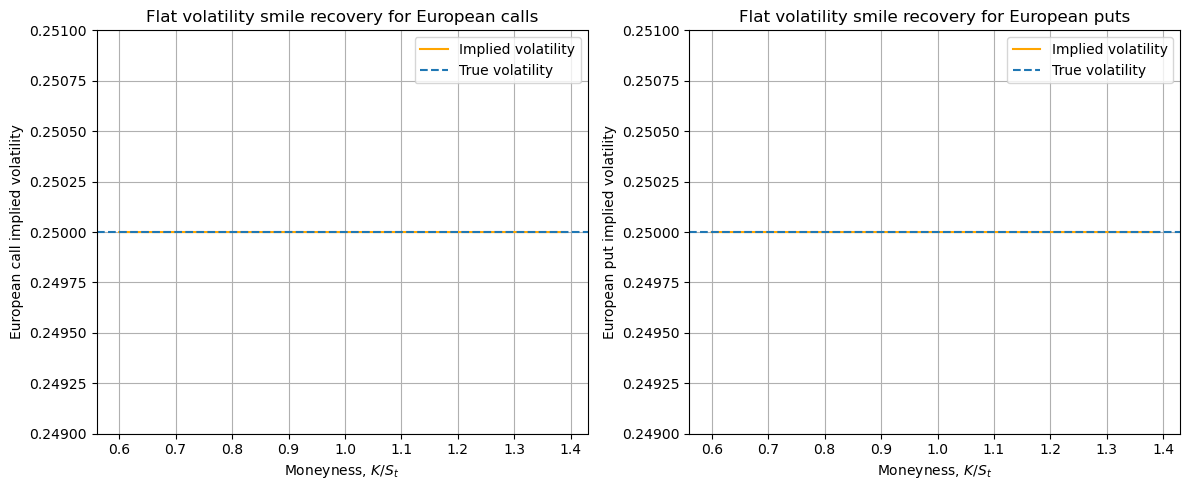

In [11]:
# Generate synthetic market prices of European call and put options using a chosen true volatility across a grid of strike prices
Ks = np.arange(60, 140, 1)
sigma_true = 0.25
C_mkt = np.array([european_bs_price(St, tau, K, r, q, sigma_true, option_type = "call") for K in Ks])
P_mkt = np.array([european_bs_price(St, tau, K, r, q, sigma_true, option_type = "put") for K in Ks])

# Compute implied volatility for given European call and put option market prices
max_iter = 50
tol = 1e-8
sigma_lower, sigma_upper = 1e-4, 2.0

sigma_imp_call = np.zeros(len(Ks))
sigma_imp_put = np.zeros(len(Ks))

for i in range(len(C_mkt)):
    sigma_imp_call[i] = implied_volatility(C_mkt[i], St, tau, Ks[i], r, q, sigma0, sigma_lower, sigma_upper, max_iter, tol, option_type = "call")
    sigma_imp_put[i] = implied_volatility(P_mkt[i], St, tau, Ks[i], r, q, sigma0, sigma_lower, sigma_upper, max_iter, tol, option_type = "put")

moneyness = Ks / St

# Plot the recovered implied volatility over the range of strike prices to show it returns the chosen true volatility
fig, (ax_call_imp, ax_put_imp) = plt.subplots(1, 2, figsize = (12, 5))

ax_call_imp.plot(moneyness, sigma_imp_call, linestyle = "-", color = "orange", label = "Implied volatility")
ax_call_imp.axhline(sigma_true, linestyle = "--", label = "True volatility")
ax_call_imp.set_ylim(sigma_true - 0.001, sigma_true + 0.001)
ax_call_imp.set_xlabel("Moneyness, $K/S_t$")
ax_call_imp.set_ylabel("European call implied volatility")
ax_call_imp.set_title("Flat volatility smile recovery for European calls")
ax_call_imp.grid()
ax_call_imp.legend()

ax_put_imp.plot(moneyness, sigma_imp_put, linestyle = "-", color = "orange", label = "Implied volatility")
ax_put_imp.set_ylim(sigma_true - 0.001, sigma_true + 0.001)
ax_put_imp.axhline(sigma_true, linestyle = "--", label = "True volatility")
ax_put_imp.set_xlabel("Moneyness, $K/S_t$")
ax_put_imp.set_ylabel("European put implied volatility")
ax_put_imp.set_title("Flat volatility smile recovery for European puts")
ax_put_imp.grid()
ax_put_imp.legend()

fig.tight_layout()
plt.show()

### Monte Carlo simulation

We simulate $M$ i.i.d. paths of the underlying asset price at terminal time under the $\mathbb{Q}$-dynamics defined earlier. For all $m = 1,\dots,M$, let $H^{(m)} := e^{-r\tau}\Psi(S_T)$ denote the discounted payoff of path $m$. Then the unbiased, consistent, and asymptotically normal Monte Carlo estimator of the option price $V(t,S_t)$ is

$$\hat{V}(t,S_t) = \frac{1}{M}\sum_{m=1}^{M}H^{(m)}$$

To simulate the path, we use the closed-form solution and avoid using any time or spatial discretisations to prevent introducing bias

$$S_T^{(m)} = S_te^{(r-q-\frac{1}{2}\sigma^2)\tau + \sigma\sqrt{\tau}Z^{(m)}}, \quad Z^{(m)} \overset{i.i.d.}{\sim}\mathcal{N}(0,1)$$

We introduce antithetic variates as a proven variance reduction technique due to the monotonicity of the payoff function. For every draw $Z^{(m)}$, we simulate another path driven by $-Z^{(m)}$. Let their respective discounted payoffs be denoted by $H_+^{(m)}$ and $H_-^{(m)}$. Our new antithetic variate for path $m$ is $\bar{H}^{(m)} = \frac{1}{2}(H_+^{(m)} + H_-^{(m)})$ so that the new Monte Carlo esitmator becomes

$$\hat{V}_{\text{anti}}(t,S_t) = \frac{1}{M} \sum_{m=1}^{M}\bar{H}^{(m)}$$

If $S_t, \tau$, or $\sigma$ is zero, we use the same boundary cases as in the Black-Sholes formula above. This means we skip the Monte Carlo simulation as the price becomes deterministic.

Using, a Bessel correction to estimate variance, the standard error and $95\%$ confidence interval is
$$ SE(\hat{V}) = \frac{S_M}{\sqrt{M}}, \quad CI = (\hat{V} - \Phi^{-1}(0.975)\frac{s_M}{\sqrt{M}}, \hat{V} + \Phi^{-1}(0.975)\frac{s_M}{\sqrt{M}})$$

Where $\Phi: \mathbb{R} \to [0,1]$ is the distribution function of a standard Gaussian random variable $Z\sim\mathcal{N}(0,1)$.

In [12]:
# Price European call and put options using Monte Carlo simulation with antithetic variates with standard error and a 95% confidence interval
def european_mc_price(St, tau, K, r, q, sigma, M, option_type, seed = None):

    """
    Computes the price of a European call or put option using Monte Carlo simulation

    Parameters:
    St: Underlying asset price at time t
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Dividend yield
    sigma: Annualised volatility
    M: Number of path simulations
    option_type: Option type
    seed: Seed for reproducibility

    Returns:
    price: European call or put option price 
    """

    epsilon = 1e-12
    
    if option_type not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'")

    if K <= 0.0:
        raise ValueError("K must be strictly positive.")

    if St < 0.0 or tau < 0.0 or sigma < 0.0:
        raise ValueError("St, tau, sigma must be non-negative.")

    if M < 2:
        raise ValueError("M must be a positive integer strictly greater than 1.")

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    Ft = St * np.exp((r - q) * tau)
    discount = np.exp(-r * tau)
    
    if St <= epsilon:
        if option_type == "call":
            price = 0.0
        else:
            price = K * discount

        std_err = 0.0
        return price, std_err, (price, price)

    elif tau <= epsilon:
        if option_type == "call":
            price = np.maximum(St - K, 0.0)
        else:
            price = np.maximum(K - St, 0.0)

        std_err = 0.0
        return price, std_err, (price, price)

    elif sigma <= epsilon:
        if option_type == "call":
            price = discount * np.maximum(Ft - K, 0.0)
        else:
            price = discount * np.maximum(K - Ft, 0.0)

        std_err = 0.0
        return price, std_err, (price, price)

    else:
        Z_pos = rng.standard_normal(size = M); Z_neg = -Z_pos
        ST_pos = np.zeros(M); ST_neg = np.zeros(M)
        H_pos = np.zeros(M); H_neg = np.zeros(M)

        drift = (r - q - 0.5 * sigma**2)*tau
        diffusion = sigma * np.sqrt(tau)
        discount = np.exp(-r * tau)

        for m in range(M):
            ST_pos[m] = St * np.exp(drift + diffusion * Z_pos[m])
            ST_neg[m] = St * np.exp(drift + diffusion * Z_neg[m])
       
            if option_type == "call":
                H_pos[m] = discount * np.maximum(ST_pos[m] - K, 0.0)
                H_neg[m] = discount * np.maximum(ST_neg[m] - K, 0.0)

            else:
                H_pos[m] = discount * np.maximum(K - ST_pos[m], 0.0)
                H_neg[m] = discount * np.maximum(K - ST_neg[m], 0.0)

        H_bar = 0.5 * (H_pos + H_neg)
    
        price = np.mean(H_bar)
        std_err = np.std(H_bar, ddof = 1) / np.sqrt(M)

        z = norm.ppf(0.975)
        CI_lower = price - (z * std_err)
        CI_upper = price + (z * std_err)

        return price, std_err, (CI_lower, CI_upper)

# Print Monte Carlo European call and put option prices with standard error and 95% confidence intervals
call_price, call_std_err, (call_lb, call_ub) = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
put_price, put_std_err, (put_lb, put_ub) = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
print(f"Monte Carlo European call: Price = {call_price:.6f}, SE = {call_std_err:.6f}, CI = ({call_lb:.6f}, {call_ub:.6f})")
print(f"Monte Carlo European put: Price = {put_price:.6f}, SE = {put_std_err:.6f}, CI = ({put_lb:.6f}, {put_ub:.6f})")

Monte Carlo European call: Price = 9.224042, SE = 0.007283, CI = (9.209768, 9.238316)
Monte Carlo European put: Price = 6.328671, SE = 0.004683, CI = (6.319493, 6.337848)


Saved: project/figures/appendixC/C3_mc_convergence_ci.pdf


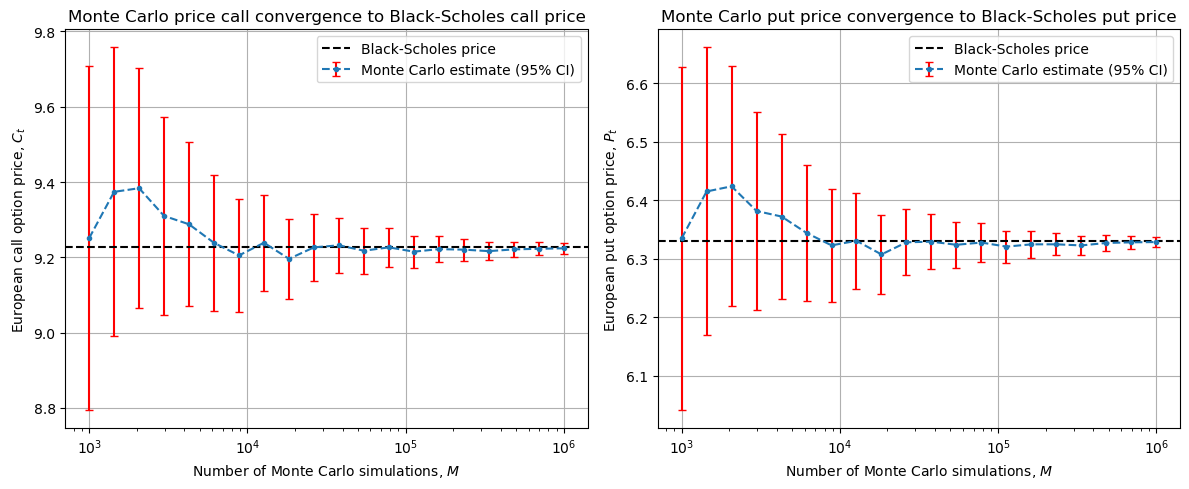

In [13]:
# Set up logarithmic x-axis and compute European Black-Scholes call and put prices
Ms = np.logspace(3, 6, num = 20, dtype = int)
bs_call = european_bs_price(St, tau, K, r, q, sigma, option_type = "call")
bs_put = european_bs_price(St, tau, K, r, q, sigma, option_type = "put")

# Create NumPy arrays for European Monte Carlo call and put prices and standard errors
mc_prices_call = []
mc_stderrs_call = []
mc_prices_put = []
mc_stderrs_put = []

for M in Ms:
    price, std_err, _ = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
    mc_prices_call.append(price)
    mc_stderrs_call.append(std_err)

for M in Ms:
    price, std_err, _ = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
    mc_prices_put.append(price)
    mc_stderrs_put.append(std_err)

mc_prices_call = np.array(mc_prices_call)
mc_stderrs_call = np.array(mc_stderrs_call)
mc_prices_put = np.array(mc_prices_put)
mc_stderrs_put = np.array(mc_stderrs_put)

# Plot convergence of European Monte Carlo call price with European Black-Scholes call price
fig, (ax_call, ax_put) = plt.subplots(1, 2, figsize = (12, 5))

ax_call.errorbar(Ms, mc_prices_call, yerr = 1.96 * mc_stderrs_call, fmt = ".--", capsize = 3, ecolor = "red", label = "Monte Carlo estimate (95% CI)")
ax_call.axhline(bs_call, linestyle = "--", label = "Black-Scholes price", color = "black")
ax_call.set_xscale("log")
ax_call.set_xlabel("Number of Monte Carlo simulations, $M$")
ax_call.set_ylabel("European call option price, $C_t$")
ax_call.set_title("Monte Carlo price call convergence to Black-Scholes call price")
ax_call.legend()
ax_call.grid()

# Plot convergence of European Monte Carlo put price with European Black-Scholes put price
ax_put.errorbar(Ms, mc_prices_put, yerr = 1.96 * mc_stderrs_put, fmt = ".--", capsize = 3, ecolor = "red", label = "Monte Carlo estimate (95% CI)")
ax_put.axhline(bs_put, linestyle = "--", color = "black", label = "Black-Scholes price")
ax_put.set_xscale("log")
ax_put.set_xlabel("Number of Monte Carlo simulations, $M$")
ax_put.set_ylabel("European put option price, $P_t$")
ax_put.set_title("Monte Carlo put price convergence to Black-Scholes put price")
ax_put.legend()
ax_put.grid()

fig.tight_layout()
save_fig(fig, "C3_mc_convergence_ci", fmt="pdf")
plt.show()

### Finite difference Greeks

To calculate the Greeks for our Monte Carlo simulation of the price of the European call and put options, we use a finite difference scheme. Specifically, a central differences method for changes in $S_t, \sigma, r$ and a backward differences method for changes in $\tau$. Let $\theta$ be the parameter of interest for which we would like to compute the greek for. Then, the central difference and backwward difference schemes can be characterised by, respectively
$$\hat{G}(\theta) = \partial_\theta \hat{V}(\theta) \approx \frac{\hat{V}(\theta + h_\theta) - \hat{V}(\theta - h_\theta)}{2h_\theta}, \quad \hat{G}(\theta) = \partial_\theta \hat{V}(\theta) \approx \frac{\hat{V}(\theta - h_\theta) - \hat{V}(\theta)}{h_\theta}$$
where $h_\theta > 0$ is a small bump relative to the size of the parameter $\theta$. Note that to in order to compute Gamma, we simply apply the central differences estimator twice to yield an approximation for the second spatial derivative $\partial_{SS}\hat{V}(\theta)$.

In [14]:
# Compute the finite difference Greeks for European Monte Carlo call and put options
def european_greek_fd(St, tau, K, r, q, sigma, M, option_type, greek_type, seed = None):

    """
    Computes the Greeks (delta, gamma, vega, rho, theta) using finite difference methods for European Monte Carlo call and put options

    Parameters:
    St: Underlying asset price
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Dividend yield
    sigma: Annualised volatility
    M: Number of path simulations
    option_type: Option type
    greek_type: Greek
    seed: Seed for reproducibility

    Returns:
    - greek: Given Greek for the chosen European option type
    """

    tol = 1e-12
    
    if option_type not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'.")
        
    if St <= tol or tau <= tol or K <= tol or sigma <= tol:
        raise ValueError("Greeks are only defined for strictly positive St, tau, K, sigma.")

    if greek_type not in ("delta", "gamma", "vega", "rho", "theta"):
        raise ValueError("greek_type must be one of 'delta', 'gamma', 'vega', 'rho', 'theta'.")
        
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    epsilon = 1e-6
    h_St = epsilon * np.maximum(St, 1e-2)
    h_tau = epsilon * np.minimum(tau, 1e-3) 
    h_r = epsilon * np.maximum(r, 1e-4)
    h_sigma = epsilon * np.maximum(sigma, 1e-4)


    if greek_type == "delta":
        St_up = St + h_St
        St_down = np.maximum(St - h_St, 0.0)
        
        if option_type == "call":
            price_St_up, _, _ = european_mc_price(St_up, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
            price_St_down, _, _ = european_mc_price(St_down, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
            delta = (price_St_up - price_St_down) / (2.0 * h_St)
        else:
            price_St_up, _, _ = european_mc_price(St_up, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
            price_St_down, _, _ = european_mc_price(St_down, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
            delta = (price_St_up - price_St_down) / (2.0 * h_St)

        return delta

    elif greek_type == "gamma":
        St_up = St + h_St
        St_down = np.maximum(St - h_St, 0.0) 
        
        if option_type == "call":
            price_St_up, _, _ = european_mc_price(St_up, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
            price_St_down, _, _ = european_mc_price(St_down, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
            price_St, _, _ = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
            gamma = (price_St_up - 2.0 * price_St + price_St_down) / (h_St**2)
        else:
            price_St_up, _, _ = european_mc_price(St_up, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
            price_St_down, _, _ = european_mc_price(St_down, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
            price_St, _, _ = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
            gamma = (price_St_up - 2.0 * price_St + price_St_down) / (h_St**2)

        return gamma

    elif greek_type == "vega":
        sigma_up = sigma + h_sigma
        sigma_down = np.maximum(sigma - h_sigma, 1e-8)        
        if option_type == "call":
            price_sigma_up, _, _ = european_mc_price(St, tau, K, r, q, sigma_up, M, option_type = "call", seed = 123)
            price_sigma_down, _, _ = european_mc_price(St, tau, K, r, q, sigma_down, M, option_type = "call", seed = 123)
            vega = (price_sigma_up - price_sigma_down) / (2.0 * h_sigma)
        else:
            price_sigma_up, _, _ = european_mc_price(St, tau, K, r, q, sigma_up, M, option_type = "put", seed = 123)
            price_sigma_down, _, _ = european_mc_price(St, tau, K, r, q, sigma_down, M, option_type = "put", seed = 123)
            vega = (price_sigma_up - price_sigma_down) / (2.0 * h_sigma)

        return vega

    elif greek_type == "rho":
        r_up = r + h_r
        r_down = r - h_r
        
        if option_type == "call":
            price_r_up, _, _ = european_mc_price(St, tau, K, r_up, q, sigma, M, option_type = "call", seed = 123)
            price_r_down, _, _ = european_mc_price(St, tau, K, r_down, q, sigma, M, option_type = "call", seed = 123)
            rho = (price_r_up - price_r_down) / (2.0 * h_r)
        else:
            price_r_up, _, _ = european_mc_price(St, tau, K, r_up, q, sigma, M, option_type = "put", seed = 123)
            price_r_down, _, _ = european_mc_price(St, tau, K, r_down, q, sigma, M, option_type = "put", seed = 123)
            rho = (price_r_up - price_r_down) / (2.0 * h_r)

        return rho

    else:
        if tau > 0:
            if option_type == "call":
                price_tau_down, _, _ = european_mc_price(St, tau - h_tau, K, r, q, sigma, M, option_type = "call", seed = 123)
                price_tau, _, _ = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "call", seed = 123)
                theta = (price_tau_down - price_tau) / h_tau
            else:
                price_tau_down, _, _ = european_mc_price(St, tau - h_tau, K, r, q, sigma, M, option_type = "put", seed = 123)
                price_tau, _, _ = european_mc_price(St, tau, K, r, q, sigma, M, option_type = "put", seed = 123)
                theta = (price_tau_down - price_tau) / h_tau
        else:
            theta = 0.0

        return theta

# Print finite difference delta for European call and put options
print(f"European Monte Carlo call finite difference delta: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'call', greek_type = 'delta'):.6f}")
print(f"European Monte Carlo put finite difference delta: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'put', greek_type = 'delta'):.6f}")

# Print finite difference gamma for European call and put options
print(f"European Monte Carlo call finite difference gamma: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'call', greek_type = 'gamma'):.6f}")
print(f"European Monte Carlo put finite difference gamma: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'put', greek_type = 'gamma'):.6f}")

# Print finite difference vega for European call and put options
print(f"European Monte Carlo call finite difference vega: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'call', greek_type = 'vega'):.6f}")
print(f"European Monte Carlo put finite difference vega: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'put', greek_type = 'vega'):.6f}")

# Print finite difference rho for European call and put options
print(f"European Monte Carlo call finite difference rho: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'call', greek_type = 'rho'):.6f}")
print(f"European Monte Carlo put finite difference rho: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'put', greek_type = 'rho'):.6f}")

# Print finite difference theta for European call and put options
print(f"European Monte Carlo call finite difference theta: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'call', greek_type = 'theta'):.6f}")
print(f"European Monte Carlo put finite difference theta: {european_greek_fd(St, tau, K, r, q, sigma, M, option_type = 'put', greek_type = 'theta'):.6f}")

European Monte Carlo call finite difference delta: 0.586743
European Monte Carlo put finite difference delta: -0.393440
European Monte Carlo call finite difference gamma: 0.024708
European Monte Carlo put finite difference gamma: 0.024707
European Monte Carlo call finite difference vega: 37.883871
European Monte Carlo put finite difference vega: 37.899259
European Monte Carlo call finite difference rho: 49.450236
European Monte Carlo put finite difference rho: -45.672707
European Monte Carlo call finite difference theta: -5.087411
European Monte Carlo put finite difference theta: -2.293171
